In [3]:
!pip install torch torchvision Pillow tqdm torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchinfo-1.7.1-py3-none-any.whl (22 kB)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

In [5]:
train_transform = transforms.Compose([
  transforms.RandomRotation(degrees=30),
  transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
  transforms.RandomAffine(degrees=0, scale=(0.5, 1)),
  transforms.RandomAffine(degrees=0, shear=(-10, 10, -10, 10)),
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081) # mean and std of mnist dataset
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081)
])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=test_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



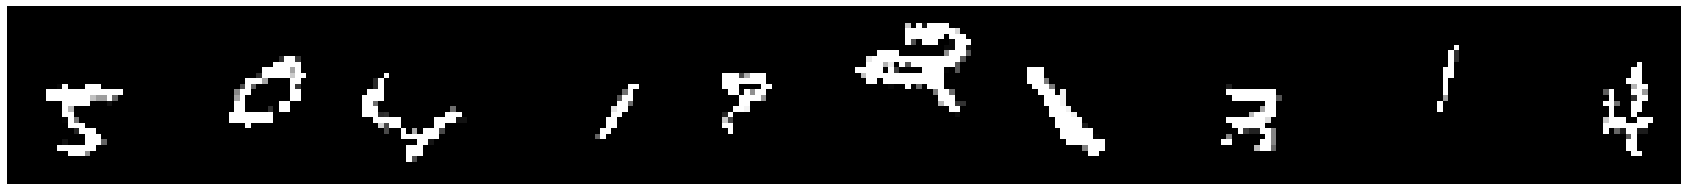

In [7]:
# Get the first 10 training examples and their labels
images, labels = zip(*[train_dataset[i] for i in range(10)])

# Convert the images to a tensor
images = torch.stack(images)

fig, ax = plt.subplots(figsize=(30, 10))

# Use make_grid to create a grid of images
grid = torchvision.utils.make_grid(images, nrow=10, )

# Convert the grid to a NumPy array and plot it
plt.imshow(grid.numpy().transpose((1, 2, 0)))

plt.axis('off')
plt.show()

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# clear the GPUs
torch.cuda.empty_cache()

device

device(type='cuda')

In [10]:
class CNN(nn.Module):
  def __init__(self, classes):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.LeakyReLU(0.01)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.LeakyReLU(0.01)
    )

    self.classifier = nn.Sequential(
      nn.Linear(in_features=64 * 7 * 7, out_features=64),
      nn.LeakyReLU(0.01),
      nn.Linear(in_features=64, out_features=classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    x = torch.flatten(x, 1)

    x = self.classifier(x)
    return x

In [22]:
model = CNN(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [23]:
summary(model=model, input_size=[64, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [64, 32, 28, 28]          64
│    └─MaxPool2d: 2-3                    [64, 32, 14, 14]          --
│    └─LeakyReLU: 2-4                    [64, 32, 14, 14]          --
├─Sequential: 1-2                        [64, 64, 7, 7]            --
│    └─Conv2d: 2-5                       [64, 64, 14, 14]          18,496
│    └─BatchNorm2d: 2-6                  [64, 64, 14, 14]          128
│    └─MaxPool2d: 2-7                    [64, 64, 7, 7]            --
│    └─LeakyReLU: 2-8                    [64, 64, 7, 7]            --
├─Sequential: 1-3                        [64, 10]                  --
│    └─Linear: 2-9                       [64, 64]                  200,768
│   

In [24]:
for epoch in tqdm(range(32)):
  model.train()

  train_acc = 0.0
  train_loss = 0.0
  train_size = len(train_loader)
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() # update the weights and biases

    model.zero_grad() # backward function accumulates gradients, and we don't want to mix up the gradients between the mini-batches; we 0 them out

    train_loss += loss.item() / len(labels)
    _, prediction = torch.max(outputs.data, 1)

    train_acc += int(torch.sum(prediction == labels.data)) / len(labels)
  
  # average accuracy and loss across all mini-batches
  train_acc /= train_size
  train_loss /= train_size

  model.eval()

  test_acc = 0.0
  test_size = len(test_loader)

  with torch.inference_mode():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, prediction = torch.max(outputs.data, 1)

      test_acc += int(torch.sum(prediction == labels.data)) / len(labels)

    test_acc /= test_size

  print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'.format(epoch + 1, train_loss, train_acc, test_acc))

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.0214, Train Acc: 0.5151, Test Acc: 0.7465
Epoch: 2, Train Loss: 0.0095, Train Acc: 0.8026, Test Acc: 0.9493
Epoch: 3, Train Loss: 0.0073, Train Acc: 0.8490, Test Acc: 0.9218
Epoch: 4, Train Loss: 0.0064, Train Acc: 0.8687, Test Acc: 0.9424
Epoch: 5, Train Loss: 0.0060, Train Acc: 0.8790, Test Acc: 0.9579
Epoch: 6, Train Loss: 0.0056, Train Acc: 0.8858, Test Acc: 0.9713
Epoch: 7, Train Loss: 0.0054, Train Acc: 0.8889, Test Acc: 0.9614
Epoch: 8, Train Loss: 0.0052, Train Acc: 0.8927, Test Acc: 0.9730
Epoch: 9, Train Loss: 0.0051, Train Acc: 0.8960, Test Acc: 0.9686
Epoch: 10, Train Loss: 0.0051, Train Acc: 0.8953, Test Acc: 0.9688
Epoch: 11, Train Loss: 0.0049, Train Acc: 0.8998, Test Acc: 0.9651
Epoch: 12, Train Loss: 0.0048, Train Acc: 0.9008, Test Acc: 0.9708
Epoch: 13, Train Loss: 0.0048, Train Acc: 0.9011, Test Acc: 0.9752
Epoch: 14, Train Loss: 0.0047, Train Acc: 0.9041, Test Acc: 0.9570
Epoch: 15, Train Loss: 0.0047, Train Acc: 0.9038, Test Acc: 0.9718
Epoc